<a href="https://colab.research.google.com/github/ayberkozcan/pytorch-computer-vision/blob/main/Object_Classification_with_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Classification with CIFAR-10

In this notebook, we are going to load the CIFAR-10 dataset, use some pretrained models, and compare their performance.

## Importing Libraries

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}\nTorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Downloading CIFAR-10 Dataset

In [3]:
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    transform=ToTensor(),
    target_transform=None,
    download=True
)
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    transform=ToTensor(),
    download=True
)

100%|██████████| 170M/170M [00:05<00:00, 31.0MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


## Exploring our Dataset

In [4]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(50000, 50000, 10000, 10000)

There are 50.000 training samples and 10.000 testing samples.

In [5]:
# Let's see classes
class_names = train_data.classes

print(f"Class shape: {len(class_names)}")
print(f"Classes\n{class_names}")

Class shape: 10
Classes
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Image shape: torch.Size([3, 32, 32])


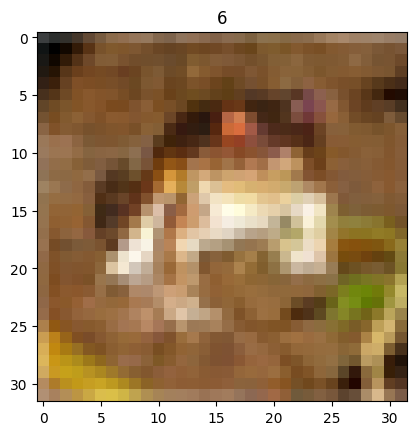

In [6]:
# Let's see a sample and learn its shape
image, label = train_data[0]

print(f"Image shape: {image.shape}")
plt.imshow(image.permute(1, 2, 0))
plt.title(label)
plt.show()

We changed the shape from (3, 32, 32) to (32, 32, 3), making it compatible with imshow.

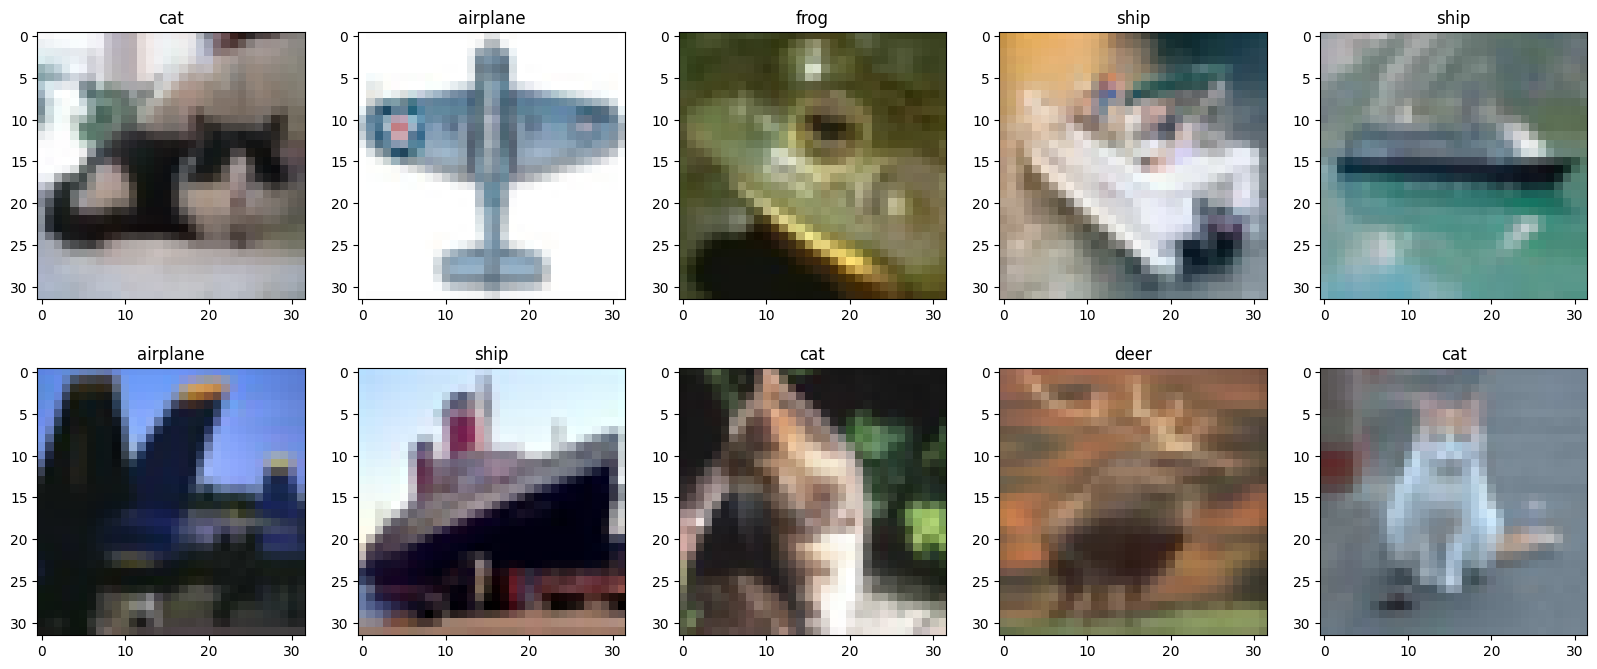

In [7]:
# Let's plot more images to explore our data
fig = plt.figure(figsize=(20, 8))
rows, cols = 2, 5
for i in range(1, rows * cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.permute(1, 2, 0))
  plt.title(class_names[label])

plt.show()

## Data Augmentation

We might augment our data a little to improve model performance when classifying more challenging images.

In [8]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

In [9]:
train_data_transformed = datasets.CIFAR10(
    root="data",
    train=True,
    transform=transform,
    target_transform=None,
    download=True
)
test_data_transformed = datasets.CIFAR10(
    root="data",
    train=False,
    transform=transform,
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


Image shape: torch.Size([3, 32, 32])


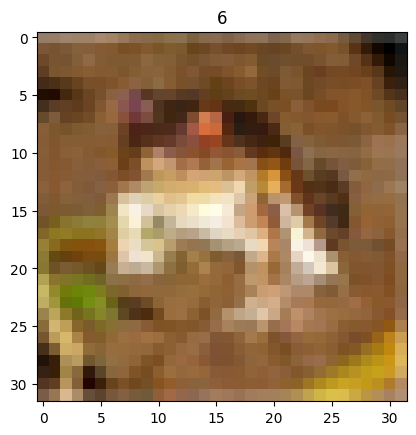

In [10]:
# Let's see a sample and learn its shape
image, label = train_data_transformed[0]

print(f"Image shape: {image.shape}")
plt.imshow(image.permute(1, 2, 0))
plt.title(label)
plt.show()

## Preparing Data with DataLoader

In [11]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 1

train_dataloader = DataLoader(
    train_data_transformed,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)
test_dataloader = DataLoader(
    test_data_transformed,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

In [12]:
print(f"Length of train dataloader: {len(train_dataloader)}")
print(f"Length of test dataloader: {len(test_dataloader)}")

Length of train dataloader: 1563
Length of test dataloader: 313


## Transfer Learning

We're going to be using pretrained Efficientnet model.

In [13]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 96.3MB/s]


We can use summary() to get information about our pretrained model.

In [14]:
try:
  from torchinfo import summary
except:
  !pip install -q torchinfo
  from torchinfo import summary

summary(
    model=model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

We can freeze base layers.

In [15]:
for param in model.features.parameters():
  param.requires_grad = False

In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

in_shape = model.classifier[1].in_features
output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(
        in_features=in_shape,
        out_features=output_shape,
        bias=True
    )
).to(device)

Let's see what's changed

In [17]:
summary(
    model=model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Train model

DataLoaders and pretrained model are ready for train.

In [18]:
loss_fn = nn.CrossEntropyLoss() # multi-class classification
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [19]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [20]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from tqdm.auto import tqdm

from timeit import default_timer as timer
train_time_start = timer()

epochs = 10

results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n--------")

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    model.train()

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    train_acc += accuracy_fn(
        y_true=y,
        y_pred=y_pred.argmax(dim=1)
    )

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)

      loss = loss_fn(test_pred, y)
      test_loss += loss

      accuracy = accuracy_fn(
          y_true=y, y_pred=test_pred.argmax(dim=1)
      )
      test_acc += accuracy

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"\nTrain Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f}%, Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%\n")

  results["train_loss"].append(train_loss.item()) if isinstance(train_loss, torch.Tensor) else train_loss
  results["train_acc"].append(train_acc.item()) if isinstance(train_acc, torch.Tensor) else train_acc
  results["test_loss"].append(test_loss.item()) if isinstance(test_loss, torch.Tensor) else test_loss
  results["test_acc"].append(test_acc.item()) if isinstance(test_acc, torch.Tensor) else test_acc

train_time_end = timer()
total_time = train_time_end - train_time_start

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
--------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train Loss: 1.94576 | Train Accuracy: 31.97%, Test Loss: 1.86088 | Test Accuracy: 35.58%

Epoch: 1
--------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train Loss: 1.91244 | Train Accuracy: 33.71%, Test Loss: 1.88260 | Test Accuracy: 34.95%

Epoch: 2
--------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train Loss: 1.91454 | Train Accuracy: 33.72%, Test Loss: 1.87802 | Test Accuracy: 35.42%

Epoch: 3
--------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train Loss: 1.91626 | Train Accuracy: 33.54%, Test Loss: 1.84903 | Test Accuracy: 35.88%

Epoch: 4
--------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samp

Our model doesn't seem to have done well. Let's try a custom model.

In [123]:
class CIFARModel(nn.Module):
  def __init__(self, input_shape=784, hidden_units=128, output_shape=10):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )
  def forward(self, x):
    return self.layer_stack(x)

In [132]:
model_2 = CIFARModel(
    input_shape=3 * 32 * 32,
    hidden_units=128,
    output_shape=10
).to(device)
model_2

CIFARModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [135]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.001)

In [136]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from tqdm.auto import tqdm

from timeit import default_timer as timer
train_time_start = timer()

epochs = 10

results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n--------")

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    model_2.train()

    y_pred = model_2(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    train_acc += accuracy_fn(
        y_true=y,
        y_pred=y_pred.argmax(dim=1)
    )

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  test_loss, test_acc = 0, 0

  model_2.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)
      test_pred = model_2(X)

      loss = loss_fn(test_pred, y)
      test_loss += loss

      accuracy = accuracy_fn(
          y_true=y, y_pred=test_pred.argmax(dim=1)
      )
      test_acc += accuracy

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"\nTrain Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f}%, Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%\n")

  results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
  results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
  results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
  results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

train_time_end = timer()
total_time = train_time_end - train_time_start

print(f"Total Time: {total_time} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
--------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train Loss: 1.55210 | Train Accuracy: 44.63%, Test Loss: 1.53949 | Test Accuracy: 45.53%

Epoch: 1
--------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train Loss: 1.51182 | Train Accuracy: 46.56%, Test Loss: 1.52743 | Test Accuracy: 46.11%

Epoch: 2
--------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train Loss: 1.50157 | Train Accuracy: 47.03%, Test Loss: 1.52137 | Test Accuracy: 46.20%

Epoch: 3
--------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train Loss: 1.49536 | Train Accuracy: 47.31%, Test Loss: 1.51575 | Test Accuracy: 46.29%

Epoch: 4
--------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samp

Our custom model has a bad performance as well (better than the first model). Let's visualize loss and accuracy for further information.

## Evaluation

### Loss and Accuracy Plots

In [137]:
loss = results["train_loss"]
test_loss = results["test_loss"]

accuracy = results["train_acc"]
test_accuracy = results["test_acc"]

epochs = range(len(results["train_loss"]))

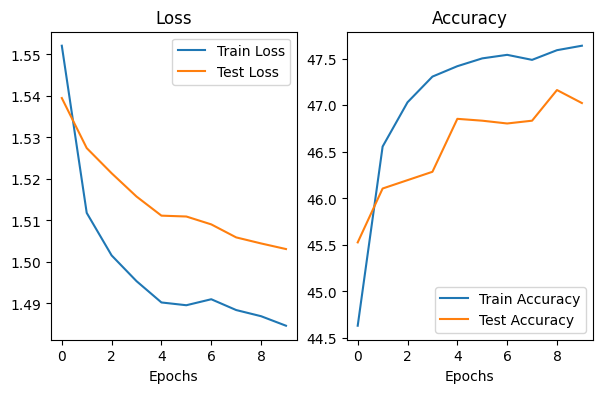

In [138]:
plt.figure(figsize=(7, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label="Train Loss")
plt.plot(epochs, test_loss, label="Test Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label="Train Accuracy")
plt.plot(epochs, test_accuracy, label="Test Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend();

### Confusion Matrix

In [139]:
from tqdm.auto import tqdm

y_preds = []

model_2.to(device)

model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making Predictions"):
    X, y = X.to(device), y.to(device)

    y_logit = model_2(X)

    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

    y_preds.append(y_pred)

y_pred_tensor = torch.cat(y_preds)

Making Predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [141]:
try:
  import torchmetrics, mlxtend
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print("Installation done!")

In [142]:
print(f"torchmetrics version: {torchmetrics.__version__}")
print(f"mlxtend version: {mlxtend.__version__}")

torchmetrics version: 1.6.1
mlxtend version: 0.23.4


In [143]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

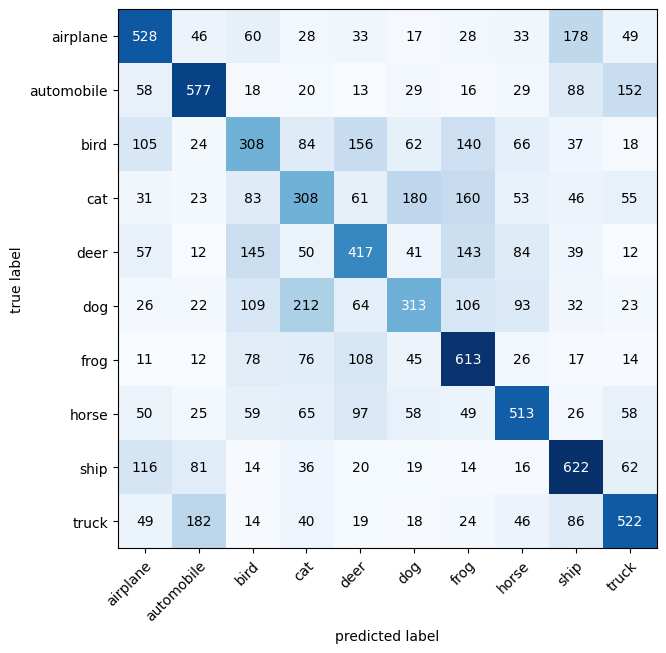

In [202]:
confmat = ConfusionMatrix(
    num_classes=len(class_names),
    task="multiclass"
).to(device)
confmat_tensor = confmat(
    preds=y_pred_tensor,
    target=torch.tensor(test_data.targets).to(device)
)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.cpu().numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

## Making Prediction on a Custom Object

In [203]:
import requests

custom_image_path = "horse.jpg"

In [204]:
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}")

Custom image tensor:
tensor([[[15, 15, 15,  ..., 23, 19, 14],
         [15, 15, 15,  ..., 24, 22, 20],
         [15, 15, 15,  ..., 26, 25, 24],
         ...,
         [49, 40, 35,  ..., 14, 13, 11],
         [45, 38, 33,  ..., 11, 12, 16],
         [33, 33, 33,  ..., 12, 16, 22]],

        [[17, 17, 17,  ..., 38, 34, 30],
         [17, 17, 17,  ..., 39, 37, 36],
         [17, 17, 17,  ..., 41, 40, 40],
         ...,
         [50, 41, 34,  ..., 30, 25, 23],
         [50, 43, 35,  ..., 25, 24, 26],
         [40, 40, 38,  ..., 26, 26, 32]],

        [[29, 29, 29,  ..., 35, 31, 27],
         [29, 29, 29,  ..., 36, 34, 33],
         [29, 29, 29,  ..., 38, 37, 37],
         ...,
         [44, 33, 29,  ..., 29, 25, 23],
         [44, 36, 30,  ..., 25, 24, 27],
         [33, 33, 32,  ..., 26, 27, 33]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 2334, 3502])


Let's convert the tensor values to float32.

In [205]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

custom_image = custom_image / 255

print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")

Custom image tensor:
tensor([[[0.0588, 0.0588, 0.0588,  ..., 0.0902, 0.0745, 0.0549],
         [0.0588, 0.0588, 0.0588,  ..., 0.0941, 0.0863, 0.0784],
         [0.0588, 0.0588, 0.0588,  ..., 0.1020, 0.0980, 0.0941],
         ...,
         [0.1922, 0.1569, 0.1373,  ..., 0.0549, 0.0510, 0.0431],
         [0.1765, 0.1490, 0.1294,  ..., 0.0431, 0.0471, 0.0627],
         [0.1294, 0.1294, 0.1294,  ..., 0.0471, 0.0627, 0.0863]],

        [[0.0667, 0.0667, 0.0667,  ..., 0.1490, 0.1333, 0.1176],
         [0.0667, 0.0667, 0.0667,  ..., 0.1529, 0.1451, 0.1412],
         [0.0667, 0.0667, 0.0667,  ..., 0.1608, 0.1569, 0.1569],
         ...,
         [0.1961, 0.1608, 0.1333,  ..., 0.1176, 0.0980, 0.0902],
         [0.1961, 0.1686, 0.1373,  ..., 0.0980, 0.0941, 0.1020],
         [0.1569, 0.1569, 0.1490,  ..., 0.1020, 0.1020, 0.1255]],

        [[0.1137, 0.1137, 0.1137,  ..., 0.1373, 0.1216, 0.1059],
         [0.1137, 0.1137, 0.1137,  ..., 0.1412, 0.1333, 0.1294],
         [0.1137, 0.1137, 0.1137,  ..

Let's see our image.

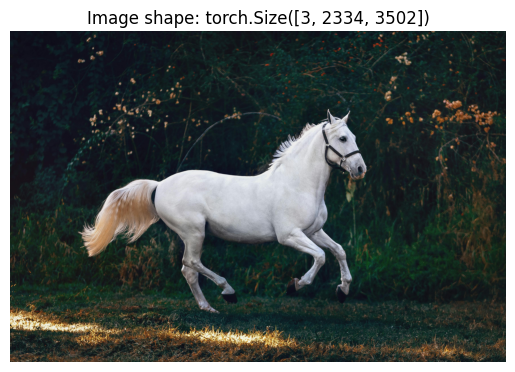

In [206]:
plt.imshow(custom_image.permute(1, 2, 0)) # CHW -> HWC
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [207]:
print(f"Custom image shape: {custom_image.shape}")
print(f"Image in dataset shape: {image.shape}")

Custom image shape: torch.Size([3, 2334, 3502])
Image in dataset shape: torch.Size([3, 32, 32])


Color channel numbers are equal but we need to resize our image.

In [208]:
from torchvision import transforms

custom_image_transform = transforms.Compose([
    transforms.Resize((32, 32))
])

custom_image_transformed = custom_image_transform(custom_image)

print(f"Original shape: {custom_image.shape}\n")
print(f"Transformed shape: {custom_image_transformed.shape}")
print(f"Image in dataset shape: {image.shape}")

Original shape: torch.Size([3, 2334, 3502])

Transformed shape: torch.Size([3, 32, 32])
Image in dataset shape: torch.Size([3, 32, 32])


Let's see our resized custom image.

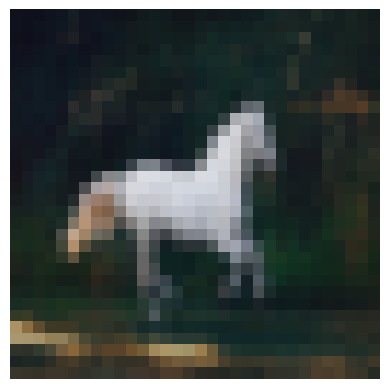

In [209]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))
plt.axis(False);

In [210]:
model_2.eval()
with torch.inference_mode():
  custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0).to(device)

  print(f"Custom image transformed shape: {custom_image_transformed.shape}")
  print(f"Custom image shape with batch size: {custom_image_transformed_with_batch_size.shape}")

  custom_image_pred = model_2(custom_image_transformed_with_batch_size)

Custom image transformed shape: torch.Size([3, 32, 32])
Custom image shape with batch size: torch.Size([1, 3, 32, 32])


In [211]:
print(model_2)

CIFARModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [212]:
custom_image_pred

tensor([[ 1.4610, -0.3621,  0.7196, -0.8785, -0.1945, -1.5552, -0.9959,  1.6768,
         -0.9509, -0.9737]], device='cuda:0')

In [213]:
print(f"Prediction Logits: {custom_image_pred}")

custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction Logits: tensor([[ 1.4610, -0.3621,  0.7196, -0.8785, -0.1945, -1.5552, -0.9959,  1.6768,
         -0.9509, -0.9737]], device='cuda:0')
Prediction probabilities: tensor([[0.2875, 0.0464, 0.1370, 0.0277, 0.0549, 0.0141, 0.0246, 0.3568, 0.0258,
         0.0252]], device='cuda:0')
Prediction label: tensor([7], device='cuda:0')


In [214]:
custom_image_pred_class = class_names[custom_image_pred_label]
custom_image_pred_class

'horse'